## Welcome to the `deeplabv3` Workshop!
In this workshop, we'll learn the concept of how to use deeplabv3 model (involving Atrous convolutions, Atrous Spatial Pyramid Pooling) for Semantic Segmentation using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define deeplabv3 model using resnet50, Atrous convolutions, ASPP modules
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

In [1]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 647.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=164a846e8585bac1317756092352983ee1cf88421fe537316853cbfa781bc16b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=28f03a4691551a9bee0742b11e4f5cca7d9bc260711408d28e64b8b93edf685e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Basic Imports

In [2]:
# basic imports
import random
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [3]:
ENVIRONMENT = 'kaggle'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

In [4]:
targetWidth = 320
targetHeight = 180

# batch size for data loaders
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 8

# Hyperparameters
N_EPOCHS = 10
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'deeplabv3_resnet50_baseline_os8'

In [5]:
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


## Torch Dataset definition

In [6]:
class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf=None):
        """Dataset class for BDD100k_dataset drivable / segmentation data """
        self.images = images
        self.labels = labels
        self.tf = tf
    
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image  

In [7]:
# Convert to torch tensor and normalize images using Imagenet values
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

data = BDD100k_dataset(images, labels, tf=preprocess)

Splitting Training data into train and validation sets, creating Dataloaders

In [8]:
# split train data into train, validation and test sets
total_count = len(data)
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_set, val_set, test_set = torch.utils.data.random_split(data, 
            (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE,drop_last=True)
val_dataloader   = DataLoader(val_set, batch_size=TEST_BATCH_SIZE)
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

Let's verify size of images from the dataset

In [9]:
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

In [10]:
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [ 
             Label("direct", 0, (219, 94, 86)),        # red
             Label("alternative", 1, (86, 211, 219)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black          
            ]
train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

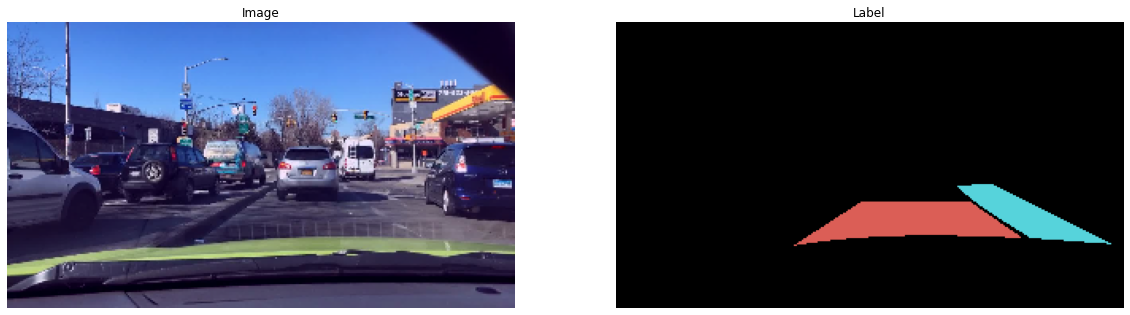

In [11]:
# when using torch datasets we defined earlier, the output image
# is normalized. So we're defining an inverse transformation to 
# transform to normal RGB format
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

rgb_image, label = train_set[random.randint(0, len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define deeplabv3 model using resnet50, Atrous convolutions, ASPP modules

In [12]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, dilation=dilation_rate, padding=dilation_rate, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        return self.conv(x)

In [13]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

In [14]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])
        
        # skip-connection, match the output channels
        # using 1x1 convolutions
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))
        
        # spatial pyramid pooling wiht atrous convolutions
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))
            
        # image pooling layer
        layers.append(aspp_pool(in_channels, out_channels))
        
        # create Pytorch module list
        self.layers = nn.ModuleList(layers)
        
        # 1x1 convolution to project concatenated output
        # to desired number of channels
        self.project = nn.Sequential(
            nn.Conv2d(len(layers) * out_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        conv_outputs = []
        for mod in self.layers:
            mod_output = mod(x)
            conv_outputs.append(mod_output)
        
        # concatenate output and reduce num_channels
        output = self.project(torch.cat(conv_outputs, dim=1))
        return output

In [15]:
from torchvision.models import resnet50 

class deeplabv3(nn.Module):
    def __init__(self, in_channels, output_stride, num_classes):
        super(deeplabv3, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.output_stride = output_stride
        
        if(output_stride == 16):
            dilation_rates = [6, 12, 18]
            replace_stride_with_dilation = [False, False, True]
            
        elif(output_stride == 8):
            dilation_rates = [12, 24, 36]
            replace_stride_with_dilation=[False, True, True]
                        
        # backbone layers
        backbone = resnet50(pretrained=True, replace_stride_with_dilation=replace_stride_with_dilation)        
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # ASPP modules
        aspp_out_channels = 256
        aspp_in_channels = int(backbone.fc.in_features)        
        self.aspp_module = atrous_spatial_pyramid_pooling(aspp_in_channels, 
                       out_channels=aspp_out_channels, dilation_rates=dilation_rates)
        
        # classifier 
        self.cls = nn.Sequential(
            nn.Conv2d(aspp_out_channels, aspp_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(aspp_out_channels),
            nn.ReLU(),
            nn.Conv2d(aspp_out_channels, self.num_classes, kernel_size=1))
                     
                
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # ASPP and classifier layers
        x = self.aspp_module(x)
        x = self.cls(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

# 3. Training : Train and validate model on the custom dataset


Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

## Metric - meanIoU

In [16]:
class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        """ Function finds the IoU for the input batch
        and add batch metrics to overall metrics """
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        """ Function to calculate confusion matrix on single batch """
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        """ Computes overall meanIoU metric from confusion matrix data """ 
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return mean_iu

    def reset(self):
        self.iou_metric = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

## Function to plot training curves

In [17]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

## Train validate function

In [18]:
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)                
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [19]:
def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

## Model Training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Starting 1 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 1, trainLoss:0.66986, validationLoss:0.44143, meanIoU: 0.60
Starting 2 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.93it/s]


Epoch: 2, trainLoss:0.28783, validationLoss:0.32292, meanIoU: 0.68
Starting 3 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 3, trainLoss:0.24674, validationLoss:0.38699, meanIoU: 0.67
Starting 4 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.90it/s]


Epoch: 4, trainLoss:0.21306, validationLoss:0.27904, meanIoU: 0.69
Starting 5 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.91it/s]


Epoch: 5, trainLoss:0.20365, validationLoss:0.44383, meanIoU: 0.63
Starting 6 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 6, trainLoss:0.19176, validationLoss:0.29414, meanIoU: 0.71
Starting 7 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.96it/s]


Epoch: 7, trainLoss:0.13844, validationLoss:0.25371, meanIoU: 0.74
Starting 8 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 8, trainLoss:0.10858, validationLoss:0.24027, meanIoU: 0.75
Starting 9 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 9, trainLoss:0.09300, validationLoss:0.21996, meanIoU: 0.76
Starting 10 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.89it/s]


Epoch: 10, trainLoss:0.08683, validationLoss:0.22031, meanIoU: 0.76


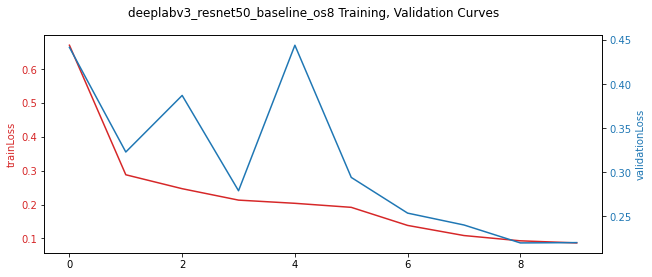

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, optimizer, lr_scheduler and pass to training function
model = deeplabv3(in_channels=3, output_stride=8, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [21]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:10<00:00,  4.04it/s]


Model has 0.7714071584750752 mean IoU in test set


In [22]:
def visualizePredictions(model : torch.nn.Module, dataSet : Dataset,  
                         device :torch.device, numTestSamples : int):
    """Function visualizes predictions of input model on samples from
    cityscapes dataset provided

    Args:
        model (torch.nn.Module): model whose output we're to visualize
        dataSet (Dataset): dataset to take samples from
        device (torch.device): compute device as in GPU, CPU etc
        numTestSamples (int): number of samples to plot
    """
    model.to(device=device)
    model.eval()

    # predictions on random samples
    testSamples = np.random.choice(len(dataSet), numTestSamples).tolist()
    _, axes = plt.subplots(numTestSamples, 3, figsize=(3*6, numTestSamples * 4))
    
    for i, sampleID in enumerate(testSamples):
        inputImage, gt = dataSet[sampleID]

        # input rgb image   
        inputImage = inputImage.to(device)
        landscape = inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()
        axes[i, 0].imshow(landscape)
        axes[i, 0].set_title("Landscape")

        # groundtruth label image
        label_class = gt.cpu().detach().numpy()
        axes[i, 1].imshow(train_id_to_color[label_class])
        axes[i, 1].set_title("Groudtruth Label")

        # predicted label image
        y_pred = torch.argmax(model(inputImage.unsqueeze(0)), dim=1).squeeze(0)
        label_class_predicted = y_pred.cpu().detach().numpy()    
        axes[i, 2].imshow(train_id_to_color[label_class_predicted])
        axes[i, 2].set_title("Predicted Label")

    plt.show()

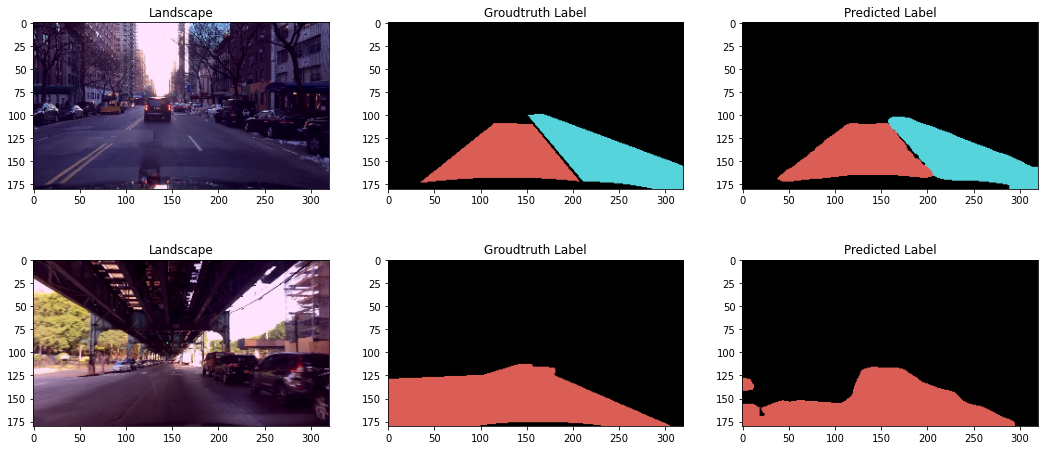

In [23]:
visualizePredictions(model, test_set, device, numTestSamples=2)

## Test on sample video

In [24]:
input_video_path = f'{dataset_path}/bdd100k_test_{targetWidth}_{targetHeight}.avi'
output_video_path = f'{output_path}/{MODEL_NAME}_output_{targetWidth}_{targetHeight}.avi'

# handles for input output videos
input_handle = cv2.VideoCapture(input_video_path)
output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 5, (targetWidth, targetHeight))

# create progress bar
num_frames = int(input_handle.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total = num_frames, position=0, leave=True)

while(input_handle.isOpened()):
    ret, frame = input_handle.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # create torch tensor to give as input to model
        pt_image = preprocess(frame)
        pt_image = pt_image.to(device)

        # get model prediction and convert to corresponding color
        y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
        predicted_labels = y_pred.cpu().detach().numpy()
        cm_labels = (train_id_to_color[predicted_labels]).astype(np.uint8)

        # overlay prediction over input frame
        overlay_image = cv2.addWeighted(frame, 1, cm_labels, 0.25, 0)
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

        # write output result and update progress
        output_handle.write(overlay_image)
        pbar.update(1)

    else:
        break

output_handle.release()
input_handle.release()

 99%|█████████▉| 161/163 [00:05<00:00, 25.36it/s]